# 08 - Corpus Analysis for RAG

Analyze the Teamleader Focus documentation corpus before building the RAG system.

**Goals:**
- Understand document size distribution (chars, words, tokens)
- Identify empty/thin documents (Training Videos, etc.)
- Estimate embedding costs
- Project LLM enrichment costs
- Category/section breakdown

In [1]:
pip install pyyaml pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import json
from pathlib import Path
from collections import Counter, defaultdict

# Try to import yaml, fall back to simple parser if not available
try:
    import yaml
    HAS_YAML = True
except ImportError:
    print("PyYAML not found. Install with: pip install pyyaml")
    print("Using simple frontmatter parser instead.")
    HAS_YAML = False

# For visualization
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    HAS_VIZ = True
except ImportError:
    print("Install pandas and matplotlib for visualizations: pip install pandas matplotlib")
    HAS_VIZ = False

Matplotlib is building the font cache; this may take a moment.


## 1. Load All Documents

In [3]:
DOCS_DIR = Path('.')  # Assuming notebook is in DOCS folder

def parse_frontmatter_simple(yaml_text: str) -> dict:
    """Simple YAML parser for frontmatter (fallback when PyYAML not available)."""
    result = {}
    for line in yaml_text.strip().split('\n'):
        if ':' in line:
            key, _, value = line.partition(':')
            key = key.strip()
            value = value.strip().strip('"').strip("'")
            if value:
                result[key] = value
    return result

def parse_frontmatter(content: str) -> tuple[dict, str]:
    """Extract YAML frontmatter and body from markdown content."""
    if content.startswith('---'):
        parts = content.split('---', 2)
        if len(parts) >= 3:
            try:
                if HAS_YAML:
                    frontmatter = yaml.safe_load(parts[1])
                else:
                    frontmatter = parse_frontmatter_simple(parts[1])
                body = parts[2].strip()
                return frontmatter or {}, body
            except Exception:
                pass
    return {}, content

def estimate_tokens(text: str) -> int:
    """Estimate token count (~4 chars per token for English)."""
    return len(text) // 4

def count_words(text: str) -> int:
    """Count words in text."""
    return len(text.split())

def count_images(content: str) -> int:
    """Count markdown image references."""
    return len(re.findall(r'!\[[^\]]*\]\([^)]+\)', content))

def count_links(content: str) -> int:
    """Count markdown links (not images)."""
    # Match [text](url) but not ![text](url)
    return len(re.findall(r'(?<!!)\[[^\]]+\]\([^)]+\)', content))

def count_headers(content: str) -> int:
    """Count markdown headers."""
    return len(re.findall(r'^#{1,6}\s', content, re.MULTILINE))

In [4]:
# Find all markdown files
md_files = sorted([
    f for f in DOCS_DIR.rglob('*.md')
    if not f.name.startswith('_') 
    and not f.name.startswith('.')
    and not f.name.startswith('00_')  # Skip readme
])

print(f"Found {len(md_files)} markdown files")

Found 775 markdown files


In [5]:
# Parse all documents
documents = []

for md_file in md_files:
    with open(md_file, 'r', encoding='utf-8') as f:
        content = f.read()
    
    frontmatter, body = parse_frontmatter(content)
    
    # Get relative path from DOCS folder
    rel_path = md_file.relative_to(DOCS_DIR)
    
    # Extract category from path or frontmatter
    path_parts = rel_path.parts
    category = frontmatter.get('category') or (path_parts[0] if len(path_parts) > 1 else 'Unknown')
    section = frontmatter.get('section') or (path_parts[1] if len(path_parts) > 2 else 'Unknown')
    
    doc = {
        'path': str(rel_path),
        'filename': md_file.name,
        'category': category,
        'section': section,
        'title': frontmatter.get('title', md_file.stem),
        'url': frontmatter.get('url', ''),
        'full_content': content,
        'body': body,
        'chars': len(body),
        'words': count_words(body),
        'tokens_est': estimate_tokens(body),
        'images': count_images(content),
        'links': count_links(content),
        'headers': count_headers(body),
        'has_frontmatter': bool(frontmatter),
    }
    documents.append(doc)

print(f"Parsed {len(documents)} documents")

Parsed 775 documents


## 2. Overall Statistics

In [6]:
total_chars = sum(d['chars'] for d in documents)
total_words = sum(d['words'] for d in documents)
total_tokens = sum(d['tokens_est'] for d in documents)
total_images = sum(d['images'] for d in documents)
total_links = sum(d['links'] for d in documents)

print("=" * 50)
print("OVERALL CORPUS STATISTICS")
print("=" * 50)
print(f"Total documents:        {len(documents):,}")
print(f"Total characters:       {total_chars:,}")
print(f"Total words:            {total_words:,}")
print(f"Total tokens (est):     {total_tokens:,}")
print(f"Total images:           {total_images:,}")
print(f"Total internal links:   {total_links:,}")
print()
print(f"Avg chars/doc:          {total_chars // len(documents):,}")
print(f"Avg words/doc:          {total_words // len(documents):,}")
print(f"Avg tokens/doc:         {total_tokens // len(documents):,}")
print(f"Avg images/doc:         {total_images / len(documents):.1f}")

OVERALL CORPUS STATISTICS
Total documents:        775
Total characters:       2,686,079
Total words:            344,552
Total tokens (est):     671,212
Total images:           2,499
Total internal links:   4,359

Avg chars/doc:          3,465
Avg words/doc:          444
Avg tokens/doc:         866
Avg images/doc:         3.2


## 3. Size Distribution

In [7]:
# Size buckets
def size_bucket(tokens: int) -> str:
    if tokens == 0:
        return "Empty (0)"
    elif tokens < 50:
        return "Tiny (<50)"
    elif tokens < 200:
        return "Small (50-200)"
    elif tokens < 500:
        return "Medium (200-500)"
    elif tokens < 1000:
        return "Large (500-1000)"
    elif tokens < 2000:
        return "Very Large (1000-2000)"
    else:
        return "Huge (2000+)"

# Categorize documents
for doc in documents:
    doc['size_bucket'] = size_bucket(doc['tokens_est'])

# Count by bucket
bucket_order = ["Empty (0)", "Tiny (<50)", "Small (50-200)", "Medium (200-500)", 
                "Large (500-1000)", "Very Large (1000-2000)", "Huge (2000+)"]
bucket_counts = Counter(d['size_bucket'] for d in documents)

print("=" * 50)
print("DOCUMENT SIZE DISTRIBUTION (by estimated tokens)")
print("=" * 50)
for bucket in bucket_order:
    count = bucket_counts.get(bucket, 0)
    pct = count / len(documents) * 100
    bar = '█' * int(pct / 2)
    print(f"{bucket:25} {count:4} ({pct:5.1f}%) {bar}")

DOCUMENT SIZE DISTRIBUTION (by estimated tokens)
Empty (0)                    0 (  0.0%) 
Tiny (<50)                  41 (  5.3%) ██
Small (50-200)              97 ( 12.5%) ██████
Medium (200-500)           177 ( 22.8%) ███████████
Large (500-1000)           235 ( 30.3%) ███████████████
Very Large (1000-2000)     155 ( 20.0%) ██████████
Huge (2000+)                70 (  9.0%) ████


/var/folders/lf/blr4851s7blg34td868_3lch0000gn/T/ipykernel_7371/3615930564.py:31: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/lf/blr4851s7blg34td868_3lch0000gn/T/ipykernel_7371/3615930564.py:31: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gent.thaqi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gent.thaqi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


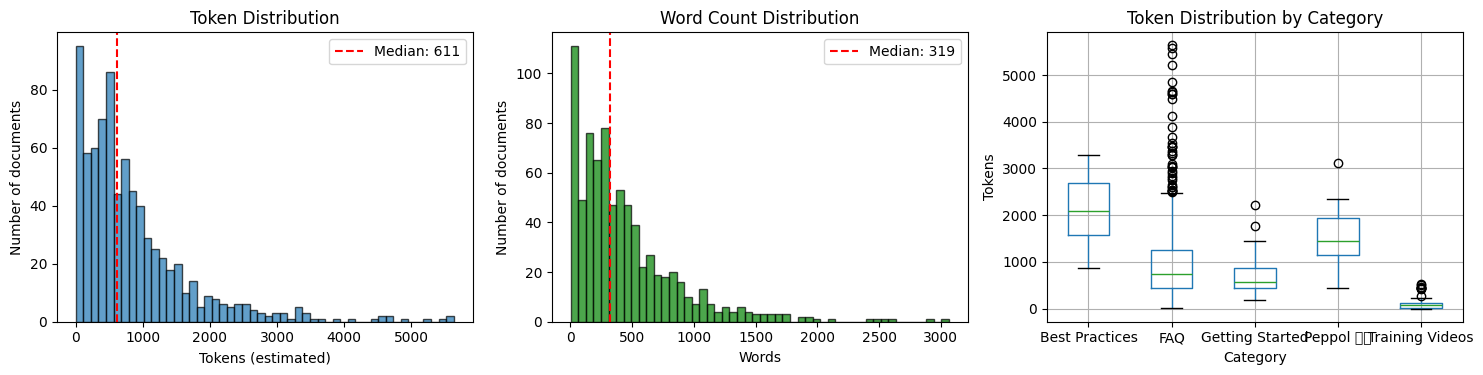

In [9]:
if HAS_VIZ:
    df = pd.DataFrame(documents)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram of tokens
    axes[0].hist(df['tokens_est'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Tokens (estimated)')
    axes[0].set_ylabel('Number of documents')
    axes[0].set_title('Token Distribution')
    axes[0].axvline(x=df['tokens_est'].median(), color='red', linestyle='--', label=f'Median: {df["tokens_est"].median():.0f}')
    axes[0].legend()
    
    # Histogram of words
    axes[1].hist(df['words'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Number of documents')
    axes[1].set_title('Word Count Distribution')
    axes[1].axvline(x=df['words'].median(), color='red', linestyle='--', label=f'Median: {df["words"].median():.0f}')
    axes[1].legend()
    
    # Box plot by category
    top_categories = df['category'].value_counts().head(5).index.tolist()
    df_top = df[df['category'].isin(top_categories)]
    df_top.boxplot(column='tokens_est', by='category', ax=axes[2])
    axes[2].set_xlabel('Category')
    axes[2].set_ylabel('Tokens')
    axes[2].set_title('Token Distribution by Category')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.show()

## 4. Empty & Thin Documents

In [10]:
# Find empty and thin documents
empty_docs = [d for d in documents if d['tokens_est'] == 0]
tiny_docs = [d for d in documents if 0 < d['tokens_est'] < 50]

print("=" * 60)
print("EMPTY DOCUMENTS (0 tokens in body)")
print("=" * 60)
print(f"Count: {len(empty_docs)}")
print()

# Group by category
empty_by_cat = Counter(d['category'] for d in empty_docs)
for cat, count in empty_by_cat.most_common():
    print(f"  {cat}: {count}")

print()
print("Sample empty docs:")
for doc in empty_docs[:10]:
    print(f"  - {doc['path']}")
if len(empty_docs) > 10:
    print(f"  ... and {len(empty_docs) - 10} more")

EMPTY DOCUMENTS (0 tokens in body)
Count: 0


Sample empty docs:


In [11]:
print("=" * 60)
print("TINY DOCUMENTS (<50 tokens - likely just title or stub)")
print("=" * 60)
print(f"Count: {len(tiny_docs)}")
print()

# Group by category
tiny_by_cat = Counter(d['category'] for d in tiny_docs)
for cat, count in tiny_by_cat.most_common():
    print(f"  {cat}: {count}")

print()
print("Sample tiny docs:")
for doc in tiny_docs[:10]:
    print(f"  - {doc['path']} ({doc['words']} words)")

TINY DOCUMENTS (<50 tokens - likely just title or stub)
Count: 41

  Training Videos: 40
  FAQ: 1

Sample tiny docs:
  - FAQ/Projects/How_To_Link_orders_to_projects.md (8 words)
  - Training_Videos/CRM/Video_CRM.md (3 words)
  - Training_Videos/CRM/Video_Custom_fields_vs_tags.md (6 words)
  - Training_Videos/CRM/Video_Intro_to_CRM.md (6 words)
  - Training_Videos/Deals_&_Quotations/Video_Intro_to_Deals.md (6 words)
  - Training_Videos/Deals_&_Quotations/Video_Multiple_quotations_per_deal.md (13 words)
  - Training_Videos/Deals_&_Quotations/Video_What_is_a_deal_and_how_do_you_make_one.md (21 words)
  - Training_Videos/Document_layout_&_Templates/Video_Document_layout.md (11 words)
  - Training_Videos/Document_layout_&_Templates/Video_Email_templates_for_quotations,_invoices_and_meetings.md (9 words)
  - Training_Videos/Expenses/Video_Copy_function_for_expense_PDF's.md (7 words)


In [12]:
# Quality assessment
def assess_quality(doc: dict) -> str:
    """Assess document quality for RAG."""
    if doc['tokens_est'] == 0:
        return 'empty'
    elif doc['tokens_est'] < 50:
        return 'stub'
    elif doc['category'] == 'Training Videos' and doc['tokens_est'] < 100:
        return 'video_reference'
    else:
        return 'useful'

for doc in documents:
    doc['quality'] = assess_quality(doc)

quality_counts = Counter(d['quality'] for d in documents)

print("=" * 50)
print("QUALITY ASSESSMENT")
print("=" * 50)
for quality in ['useful', 'video_reference', 'stub', 'empty']:
    count = quality_counts.get(quality, 0)
    pct = count / len(documents) * 100
    print(f"{quality:20} {count:4} ({pct:5.1f}%)")

useful_docs = [d for d in documents if d['quality'] == 'useful']
print(f"\nUseful docs for RAG: {len(useful_docs)}")

QUALITY ASSESSMENT
useful                694 ( 89.5%)
video_reference        40 (  5.2%)
stub                   41 (  5.3%)
empty                   0 (  0.0%)

Useful docs for RAG: 694


## 5. Category & Section Breakdown

In [13]:
# Category breakdown
category_counts = Counter(d['category'] for d in documents)

print("=" * 50)
print("DOCUMENTS BY CATEGORY")
print("=" * 50)
for cat, count in category_counts.most_common():
    pct = count / len(documents) * 100
    # Calculate avg tokens for this category
    cat_docs = [d for d in documents if d['category'] == cat]
    avg_tokens = sum(d['tokens_est'] for d in cat_docs) // len(cat_docs) if cat_docs else 0
    print(f"{cat:25} {count:4} ({pct:5.1f}%)  avg tokens: {avg_tokens:,}")

DOCUMENTS BY CATEGORY
FAQ                        569 ( 73.4%)  avg tokens: 1,010
Training Videos            119 ( 15.4%)  avg tokens: 100
Getting Started             66 (  8.5%)  avg tokens: 682
Best Practices              12 (  1.5%)  avg tokens: 2,097
Peppol 🇧🇪                    9 (  1.2%)  avg tokens: 1,582


/var/folders/lf/blr4851s7blg34td868_3lch0000gn/T/ipykernel_7371/1867400538.py:26: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/lf/blr4851s7blg34td868_3lch0000gn/T/ipykernel_7371/1867400538.py:26: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gent.thaqi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gent.thaqi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


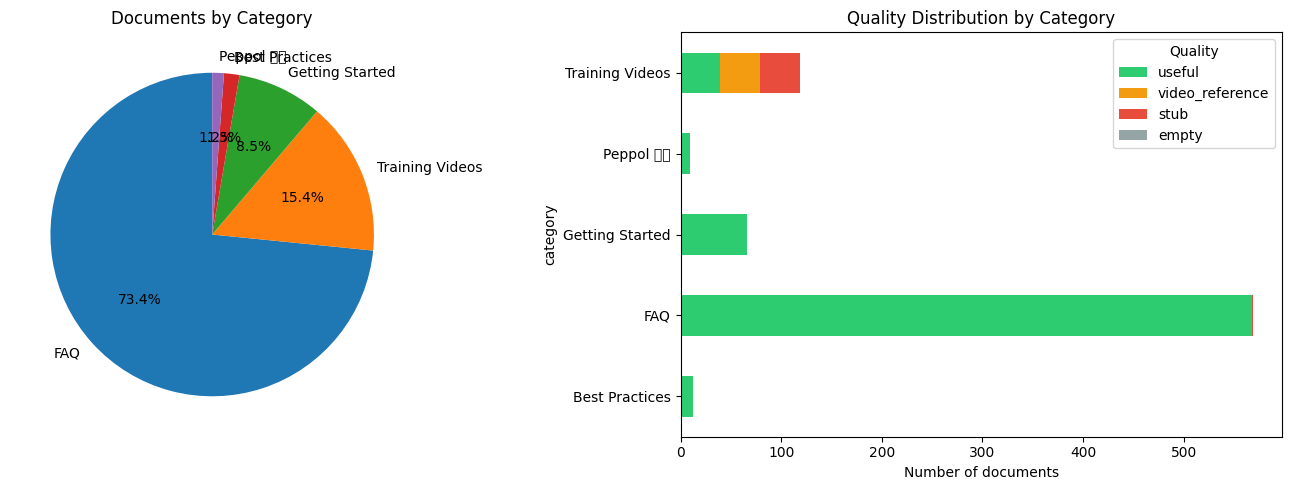

In [14]:
if HAS_VIZ:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart of categories
    cats = [c for c, _ in category_counts.most_common(6)]
    counts = [category_counts[c] for c in cats]
    other = sum(category_counts[c] for c in category_counts if c not in cats)
    if other > 0:
        cats.append('Other')
        counts.append(other)
    
    axes[0].pie(counts, labels=cats, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Documents by Category')
    
    # Bar chart of quality by category
    if HAS_VIZ:
        df = pd.DataFrame(documents)
        quality_cat = df.groupby(['category', 'quality']).size().unstack(fill_value=0)
        quality_cat = quality_cat.reindex(columns=['useful', 'video_reference', 'stub', 'empty'], fill_value=0)
        quality_cat.head(10).plot(kind='barh', stacked=True, ax=axes[1], 
                                   color=['#2ecc71', '#f39c12', '#e74c3c', '#95a5a6'])
        axes[1].set_xlabel('Number of documents')
        axes[1].set_title('Quality Distribution by Category')
        axes[1].legend(title='Quality')
    
    plt.tight_layout()
    plt.show()

## 6. Longest & Shortest Documents

In [15]:
# Sort by tokens
sorted_by_tokens = sorted(documents, key=lambda d: d['tokens_est'], reverse=True)

print("=" * 70)
print("TOP 15 LONGEST DOCUMENTS")
print("=" * 70)
print(f"{'Tokens':<8} {'Words':<8} {'Category':<20} {'Title (truncated)'}")
print("-" * 70)
for doc in sorted_by_tokens[:15]:
    title = doc['title'][:40] + '...' if len(doc['title']) > 40 else doc['title']
    print(f"{doc['tokens_est']:<8} {doc['words']:<8} {doc['category'][:20]:<20} {title}")

TOP 15 LONGEST DOCUMENTS
Tokens   Words    Category             Title (truncated)
----------------------------------------------------------------------
5632     1407     FAQ                  Features per package (SMART, GROW & FLOW...
5581     3064     FAQ                  How To: Add a project in Teamleader Focu...
5458     1910     FAQ                  Our BOOST package
5211     2937     FAQ                  How To: Create a team meeting type as an...
4853     2632     FAQ                  How To: Create a meeting type for your p...
4664     2525     FAQ                  How To: Create a meeting type for your p...
4635     2441     FAQ                  How To: The Accounting connector Booster...
4595     1566     FAQ                  Our MOVE package
4593     2474     FAQ                  How To: Contact forms and how to create ...
4485     773      FAQ                  Features per package (GO, MOVE & BOOST)
4123     950      FAQ                  Old projects vs new projects
3886  

In [16]:
# Check if any docs exceed embedding model limits
EMBEDDING_LIMIT = 8191  # text-embedding-3-small limit

over_limit = [d for d in documents if d['tokens_est'] > EMBEDDING_LIMIT]
near_limit = [d for d in documents if EMBEDDING_LIMIT * 0.8 < d['tokens_est'] <= EMBEDDING_LIMIT]

print("=" * 50)
print(f"EMBEDDING MODEL LIMIT CHECK ({EMBEDDING_LIMIT:,} tokens)")
print("=" * 50)
print(f"Documents over limit:    {len(over_limit)}")
print(f"Documents near limit (80%+): {len(near_limit)}")

if over_limit:
    print("\nDocuments exceeding limit:")
    for doc in over_limit:
        print(f"  - {doc['path']} ({doc['tokens_est']:,} tokens)")

EMBEDDING MODEL LIMIT CHECK (8,191 tokens)
Documents over limit:    0
Documents near limit (80%+): 0


## 7. Cost Projections

In [17]:
# Embedding costs (OpenAI text-embedding-3-small)
# Price: $0.02 per 1M tokens
EMBEDDING_COST_PER_M = 0.02

# Only count useful documents
useful_docs = [d for d in documents if d['quality'] == 'useful']
useful_tokens = sum(d['tokens_est'] for d in useful_docs)

# For full-doc embedding, we also add metadata header (~50 tokens per doc)
metadata_overhead = len(useful_docs) * 50
total_embedding_tokens = useful_tokens + metadata_overhead

embedding_cost = (total_embedding_tokens / 1_000_000) * EMBEDDING_COST_PER_M

print("=" * 50)
print("EMBEDDING COST PROJECTION")
print("=" * 50)
print(f"Useful documents:        {len(useful_docs)}")
print(f"Content tokens:          {useful_tokens:,}")
print(f"Metadata overhead:       {metadata_overhead:,} (~50/doc)")
print(f"Total tokens to embed:   {total_embedding_tokens:,}")
print(f"")
print(f"Model: text-embedding-3-small")
print(f"Price: ${EMBEDDING_COST_PER_M}/1M tokens")
print(f"")
print(f"Estimated cost: ${embedding_cost:.2f}")

EMBEDDING COST PROJECTION
Useful documents:        694
Content tokens:          667,449
Metadata overhead:       34,700 (~50/doc)
Total tokens to embed:   702,149

Model: text-embedding-3-small
Price: $0.02/1M tokens

Estimated cost: $0.01


In [19]:
# LLM Enrichment costs (generating summary, keywords, quality flags)
# Using Gemini Flash via OpenRouter

# Gemini 3.0 Flash pricing (OpenRouter): $0.10 input / $0.40 output per 1M tokens
LLM_INPUT_COST_PER_M = 0.50
LLM_OUTPUT_COST_PER_M = 3.00

# Estimate: ~500 tokens for prompt template + document content
# Output: ~100 tokens (summary + keywords + quality)
PROMPT_OVERHEAD = 300  # System prompt, instructions
OUTPUT_TOKENS = 100  # Generated summary, keywords, quality

total_input_tokens = sum(d['tokens_est'] + PROMPT_OVERHEAD for d in useful_docs)
total_output_tokens = len(useful_docs) * OUTPUT_TOKENS

input_cost = (total_input_tokens / 1_000_000) * LLM_INPUT_COST_PER_M
output_cost = (total_output_tokens / 1_000_000) * LLM_OUTPUT_COST_PER_M
total_llm_cost = input_cost + output_cost

print("=" * 50)
print("LLM ENRICHMENT COST PROJECTION")
print("=" * 50)
print(f"Documents to process:    {len(useful_docs)}")
print(f"")
print(f"Input tokens:            {total_input_tokens:,}")
print(f"  - Document content:    {useful_tokens:,}")
print(f"  - Prompt overhead:     {PROMPT_OVERHEAD * len(useful_docs):,}")
print(f"Output tokens:           {total_output_tokens:,}")
print(f"")
print(f"Model: Gemini 3.0 Flash (via OpenRouter)")
print(f"Price: ${LLM_INPUT_COST_PER_M}/1M input, ${LLM_OUTPUT_COST_PER_M}/1M output")
print(f"")
print(f"Input cost:              ${input_cost:.2f}")
print(f"Output cost:             ${output_cost:.2f}")
print(f"Total LLM cost:          ${total_llm_cost:.2f}")

LLM ENRICHMENT COST PROJECTION
Documents to process:    694

Input tokens:            875,649
  - Document content:    667,449
  - Prompt overhead:     208,200
Output tokens:           69,400

Model: Gemini 3.0 Flash (via OpenRouter)
Price: $0.5/1M input, $3.0/1M output

Input cost:              $0.44
Output cost:             $0.21
Total LLM cost:          $0.65


In [20]:
# Alternative: Claude Haiku pricing
CLAUDE_INPUT_COST_PER_M = 0.25
CLAUDE_OUTPUT_COST_PER_M = 1.25

claude_input_cost = (total_input_tokens / 1_000_000) * CLAUDE_INPUT_COST_PER_M
claude_output_cost = (total_output_tokens / 1_000_000) * CLAUDE_OUTPUT_COST_PER_M
claude_total = claude_input_cost + claude_output_cost

print("=" * 50)
print("ALTERNATIVE: CLAUDE HAIKU COST")
print("=" * 50)
print(f"Model: Claude 3.5 Haiku (via OpenRouter)")
print(f"Price: ${CLAUDE_INPUT_COST_PER_M}/1M input, ${CLAUDE_OUTPUT_COST_PER_M}/1M output")
print(f"")
print(f"Input cost:              ${claude_input_cost:.2f}")
print(f"Output cost:             ${claude_output_cost:.2f}")
print(f"Total Claude cost:       ${claude_total:.2f}")

ALTERNATIVE: CLAUDE HAIKU COST
Model: Claude 3.5 Haiku (via OpenRouter)
Price: $0.25/1M input, $1.25/1M output

Input cost:              $0.22
Output cost:             $0.09
Total Claude cost:       $0.31


In [21]:
# Total cost summary
print("=" * 50)
print("TOTAL COST SUMMARY")
print("=" * 50)
print(f"")
print(f"Option A: Gemini Flash + Embeddings")
print(f"  LLM enrichment:        ${total_llm_cost:.2f}")
print(f"  Embeddings:            ${embedding_cost:.2f}")
print(f"  TOTAL:                 ${total_llm_cost + embedding_cost:.2f}")
print(f"")
print(f"Option B: Claude Haiku + Embeddings")
print(f"  LLM enrichment:        ${claude_total:.2f}")
print(f"  Embeddings:            ${embedding_cost:.2f}")
print(f"  TOTAL:                 ${claude_total + embedding_cost:.2f}")
print(f"")
print(f"Option C: No LLM enrichment (metadata only)")
print(f"  Embeddings only:       ${embedding_cost:.2f}")

TOTAL COST SUMMARY

Option A: Gemini Flash + Embeddings
  LLM enrichment:        $0.65
  Embeddings:            $0.01
  TOTAL:                 $0.66

Option B: Claude Haiku + Embeddings
  LLM enrichment:        $0.31
  Embeddings:            $0.01
  TOTAL:                 $0.32

Option C: No LLM enrichment (metadata only)
  Embeddings only:       $0.01


## 8. Content Analysis

In [22]:
# Analyze document types by title patterns
def classify_doc_type(title: str) -> str:
    title_lower = title.lower()
    if title_lower.startswith('how to'):
        return 'How To'
    elif title_lower.startswith('faq'):
        return 'FAQ'
    elif title_lower.startswith('getting started'):
        return 'Getting Started'
    elif title_lower.startswith('video'):
        return 'Video'
    else:
        return 'Other'

for doc in documents:
    doc['doc_type'] = classify_doc_type(doc['title'])

type_counts = Counter(d['doc_type'] for d in documents)

print("=" * 50)
print("DOCUMENT TYPES (by title pattern)")
print("=" * 50)
for doc_type, count in type_counts.most_common():
    pct = count / len(documents) * 100
    print(f"{doc_type:20} {count:4} ({pct:5.1f}%)")

DOCUMENT TYPES (by title pattern)
How To                300 ( 38.7%)
FAQ                   248 ( 32.0%)
Video                  83 ( 10.7%)
Other                  81 ( 10.5%)
Getting Started        63 (  8.1%)


In [23]:
# Documents with most images
sorted_by_images = sorted(documents, key=lambda d: d['images'], reverse=True)

print("=" * 60)
print("TOP 10 DOCUMENTS BY IMAGE COUNT")
print("=" * 60)
for doc in sorted_by_images[:10]:
    title = doc['title'][:45] + '...' if len(doc['title']) > 45 else doc['title']
    print(f"{doc['images']:3} images  {title}")

TOP 10 DOCUMENTS BY IMAGE COUNT
 30 images  How To: What types of questions can I add to ...
 29 images  How To: Create a team meeting type as an admi...
 26 images  How To: Create a meeting type for your person...
 26 images  How To: Create a meeting type for your person...
 22 images  How To: Insights in Teamleader Focus
 21 images  How To: Using the contact widget in the Lead ...
 21 images  How To: The Accounting connector Booster in T...
 20 images  How To: Planning in Teamleader Focus
 20 images  Welcome to our Template Gallery
 17 images  How To: Invoice a project in Teamleader Focus


In [24]:
# Documents with most internal links (good for relationship mapping)
sorted_by_links = sorted(documents, key=lambda d: d['links'], reverse=True)

print("=" * 60)
print("TOP 10 DOCUMENTS BY INTERNAL LINK COUNT")
print("=" * 60)
for doc in sorted_by_links[:10]:
    title = doc['title'][:45] + '...' if len(doc['title']) > 45 else doc['title']
    print(f"{doc['links']:3} links   {title}")

TOP 10 DOCUMENTS BY INTERNAL LINK COUNT
125 links   Features per package (GO, MOVE & BOOST)
118 links   Features per package (SMART, GROW & FLOW)
 84 links   Our BOOST package
 73 links   Our MOVE package
 54 links   Our GO package
 53 links   How To: Switching to a smaller Teamleader Foc...
 52 links   How To: Insights library on CRM, Sales and Pr...
 47 links   How To: Switching to a smaller Teamleader Foc...
 44 links   Our ONE package
 42 links   Teamleader Focus for Administrative Users


## 9. Export Analysis Results

In [25]:
# Export summary for next steps
analysis_summary = {
    'total_documents': len(documents),
    'useful_documents': len(useful_docs),
    'empty_documents': len(empty_docs),
    'tiny_documents': len(tiny_docs),
    'total_tokens': total_tokens,
    'useful_tokens': useful_tokens,
    'avg_tokens_per_doc': total_tokens // len(documents),
    'documents_over_embedding_limit': len(over_limit),
    'cost_estimates': {
        'embeddings': round(embedding_cost, 2),
        'llm_enrichment_gemini': round(total_llm_cost, 2),
        'llm_enrichment_claude': round(claude_total, 2),
        'total_gemini': round(total_llm_cost + embedding_cost, 2),
        'total_claude': round(claude_total + embedding_cost, 2),
    },
    'quality_breakdown': dict(quality_counts),
    'category_breakdown': dict(category_counts),
    'size_distribution': dict(bucket_counts),
}

# Save to JSON
output_path = DOCS_DIR / '08_corpus_analysis.json'
with open(output_path, 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print(f"Analysis saved to: {output_path}")
print()
print(json.dumps(analysis_summary, indent=2))

Analysis saved to: 08_corpus_analysis.json

{
  "total_documents": 775,
  "useful_documents": 694,
  "empty_documents": 0,
  "tiny_documents": 41,
  "total_tokens": 671212,
  "useful_tokens": 667449,
  "avg_tokens_per_doc": 866,
  "documents_over_embedding_limit": 0,
  "cost_estimates": {
    "embeddings": 0.01,
    "llm_enrichment_gemini": 0.65,
    "llm_enrichment_claude": 0.31,
    "total_gemini": 0.66,
    "total_claude": 0.32
  },
  "quality_breakdown": {
    "useful": 694,
    "stub": 41,
    "video_reference": 40
  },
  "category_breakdown": {
    "Best Practices": 12,
    "FAQ": 569,
    "Getting Started": 66,
    "Peppol \ud83c\udde7\ud83c\uddea": 9,
    "Training Videos": 119
  },
  "size_distribution": {
    "Huge (2000+)": 70,
    "Very Large (1000-2000)": 155,
    "Large (500-1000)": 235,
    "Medium (200-500)": 177,
    "Small (50-200)": 97,
    "Tiny (<50)": 41
  }
}


## 10. Recommendations

In [26]:
print("=" * 60)
print("RECOMMENDATIONS FOR RAG IMPLEMENTATION")
print("=" * 60)
print()

print("1. DOCUMENT FILTERING")
print(f"   - Exclude {len(empty_docs)} empty documents")
print(f"   - Review {len(tiny_docs)} tiny documents (<50 tokens)")
print(f"   - Consider flagging 'Training Videos' as video_reference")
print(f"   - Final useful docs: {len(useful_docs)}")
print()

print("2. CHUNKING STRATEGY")
if len(over_limit) == 0:
    print(f"   ✅ No documents exceed embedding limit ({EMBEDDING_LIMIT:,} tokens)")
    print(f"   → Full document embedding is viable")
else:
    print(f"   ⚠️  {len(over_limit)} documents exceed limit")
    print(f"   → Consider chunking for large documents")
print(f"   - Median doc size: {sorted(d['tokens_est'] for d in documents)[len(documents)//2]:,} tokens")
print()

print("3. COST OPTIMIZATION")
print(f"   - Gemini Flash is cheapest: ~${total_llm_cost + embedding_cost:.2f} total")
print(f"   - Skip LLM enrichment if budget tight: ~${embedding_cost:.2f}")
print()

print("4. CONTENT QUALITY")
print(f"   - {type_counts.get('How To', 0)} 'How To' guides (step-by-step)")
print(f"   - {type_counts.get('FAQ', 0)} FAQ articles (Q&A format)")
print(f"   - Rich internal linking ({total_links:,} links) for relationship context")

RECOMMENDATIONS FOR RAG IMPLEMENTATION

1. DOCUMENT FILTERING
   - Exclude 0 empty documents
   - Review 41 tiny documents (<50 tokens)
   - Consider flagging 'Training Videos' as video_reference
   - Final useful docs: 694

2. CHUNKING STRATEGY
   ✅ No documents exceed embedding limit (8,191 tokens)
   → Full document embedding is viable
   - Median doc size: 611 tokens

3. COST OPTIMIZATION
   - Gemini Flash is cheapest: ~$0.66 total
   - Skip LLM enrichment if budget tight: ~$0.01

4. CONTENT QUALITY
   - 300 'How To' guides (step-by-step)
   - 248 FAQ articles (Q&A format)
   - Rich internal linking (4,359 links) for relationship context
